In [1]:
%load_ext autoreload
%autoreload 2
import SpectralConvxD as spc



c:\Users\jketchak\Documents\DALPHAcommunity\UNAMUR\EUREKA\btwg_ml\SpectralConvxD\SpectralConvxD\utils.py:14: SyntaxWarning: invalid escape sequence '\)'
  """


In [2]:
x_train, y_train,x_test, y_test=spc.generate_data(name_data='mnist1d')


Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...


In [24]:
models_pars={'reference':
                    {"spectral_config":{ 'is_base_trainable': True,
                                        'is_diag_start_trainable': False,
                                        'is_diag_end_trainable': False,
                                        'use_bias': True
                                        },
                     "spectral_cnn1d_config":{ 'kernel_size': 3,
                                                'stride': 1,
                                                'padding': 0,
                                                'trainable_phi':True,
                                                'use_lambda_out':False,
                                                'use_lambda_in' : False,
                                                'use_bias': True
                                              },
                     "spectral_cnn2d_config":{ 'kernel_size': 3,
                                                'strides': 1,
                                                'padding': 'VALID',
                                                "use_lambda_out":False,
                                                "use_lambda_in":False,
                                                "use_encode":False,
                                                "use_decode":False,
                                                'use_bias': True,
                                                "trainable_omega_diag":True,
                                                "trainable_omega_triu":True,
                                                "trainable_omega_tril":True,
                                                "trainable_aggregate":False,
                                                }
                    },
                    
             'Dspec':{"spectral_config":{ 'is_base_trainable': True,
                                        'is_diag_start_trainable': False,
                                        'is_diag_end_trainable': False,
                                        'use_bias': True
                                        },
                     "spectral_cnn1d_config":{ 'kernel_size': 3,
                                                'stride': 1,
                                                'padding': 0,
                                                'trainable_phi':True,
                                                'use_lambda_out':False,
                                                'use_lambda_in' : True,
                                                'use_bias': True
                                              },
                     "spectral_cnn2d_config":{ 'kernel_size': 3,
                                                'strides': 1,
                                                'padding': 'VALID',
                                                "use_lambda_out":False,
                                                "use_lambda_in":False,
                                                "use_encode":False,
                                                "use_decode":True,
                                                'use_bias': True,
                                                "trainable_omega_diag":False,
                                                "trainable_omega_triu":False,
                                                "trainable_omega_tril":False,
                                                "trainable_aggregate":False,
                                                }
                    },
             
             'specConvXd':{"spectral_config":{ 'is_base_trainable': True,
                                        'is_diag_start_trainable': False,
                                        'is_diag_end_trainable': True,
                                        'use_bias': True
                                        },
                     "spectral_cnn1d_config":{ 'kernel_size': 3,
                                                'stride': 1,
                                                'padding': 1,
                                                'trainable_phi':True,
                                                'use_lambda_out':False,
                                                'use_lambda_in' : True,
                                                'use_bias': True
                                              },
                     "spectral_cnn2d_config":{ 'kernel_size': 3,
                                                'strides': 1,
                                                'padding': 'VALID',
                                                "use_lambda_out":False,
                                                "use_lambda_in":False,
                                                "use_encode":False,
                                                "use_decode":True,
                                                'use_bias': True,
                                                "trainable_omega_diag":False,
                                                "trainable_omega_triu":False,
                                                "trainable_omega_tril":False,
                                                "trainable_aggregate":False,
                                                }
                    }
            }
models_name=list(models_pars.keys())
print(models_name)

['reference', 'Dspec', 'specConvXd']


In [32]:
maxpooling_config ={'strides': 1,
                     'padding': 'valid' }

hyperparameters = { 'filters' :20,
                    'input_shape' :(40,),
                    'learning_rate' : 0.01,
                    'epochs' : 20,
                    'batch_size' :100,
                    'activation': 'relu',
                    'labels' : 10,
                    'conxd':1,
                    'pool_size':2,
                    'pruning':None,
                    'use_pruning':True,
                    'use_base_and_Lambda':None}

In [33]:
models = spc.SpectralCnn(hyperparameters=hyperparameters,maxpooling_config=maxpooling_config)

In [40]:
inv=0
models.compile_models(units=2500,spectral_config=models_pars.get(models_name[inv]).get('spectral_config'),
                      spectral_cnn1d_config=models_pars.get(models_name[inv]).get('spectral_cnn1d_config'),
                      spectral_cnn2d_config=models_pars.get(models_name[inv]).get('spectral_cnn2d_config'),
                      name=models_name[inv])
models.summary(name=models_name[inv])

Reference model summary:
 


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ spec_conv1D (SpecCnn1D)         │ (None, 38, 20)         │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 37, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 740)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spectral_1 (Spectral)           │ (None, 2500)           │     1,852,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spectral_2 (Spectral)           │ (None, 10)             │        25,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,877,590 (7.16 MB)

 Trainable params: 1,877,590 (7.16 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
models.train(x_train, y_train, x_test, y_test, name=models_name[inv],verbose=1,layers=[3])

Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1995 - loss: 2.0668 - val_accuracy: 0.3480 - val_loss: 1.5860
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4111 - loss: 1.4641 - val_accuracy: 0.4675 - val_loss: 1.2836
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5013 - loss: 1.2359 - val_accuracy: 0.5460 - val_loss: 1.1345
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5794 - loss: 1.0688 - val_accuracy: 0.6105 - val_loss: 0.9822
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6581 - loss: 0.8965 - val_accuracy: 0.6830 - val_loss: 0.8384
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7224 - loss: 0.7423 - val_accuracy: 0.7325 - val_loss: 0.7221
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7818 - loss: 0.6103 - val_accuracy: 0.7860 - val_loss: 0.5885
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8412 - loss: 0.4705 - val_accuracy: 0.8255 - val_los

In [42]:
models.get_hyperparameters()

{'filters': 20,
 'input_shape': (40,),
 'learning_rate': 0.01,
 'epochs': 20,
 'batch_size': 100,
 'activation': 'relu',
 'labels': 10,
 'conxd': 1,
 'pool_size': 2,
 'pruning': None,
 'use_pruning': True,
 'use_base_and_Lambda': None,
 'units': 2500}

## Pruning model 

In [ ]:
replication = {'rep':1} 
depth={'N':[2500]}
drop={'p':[0.1,0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

In [44]:
path =r"C:\Users\jketchak\Documents\DALPHAcommunity\UNAMUR\EUREKA\btwg_ml\SpectralConvxD\SpectralConvxD\DataWarehouse\dtest"
path=spc.utils.remplacer_backslash(path)

In [45]:
for p in drop.get('p'):
    models.evaluate(x_test, y_test, name=models_name[inv],layers=[3],p=p,order=0,path=path)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9004 - loss: 0.3244
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8536 - loss: 0.5909
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7770 - loss: 1.3476
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7226 - loss: 2.1312
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6412 - loss: 2.7679
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5914 - loss: 3.3130
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4852 - loss: 3.3985
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3381 - loss: 4.0453
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3053 - loss: 4.3314


In [46]:
results={name : spc.extract_accuracy_and_save(replication=replication,depth=depth,drop=drop,name=name,path=path) for name in models_name if name!='Dspec'}


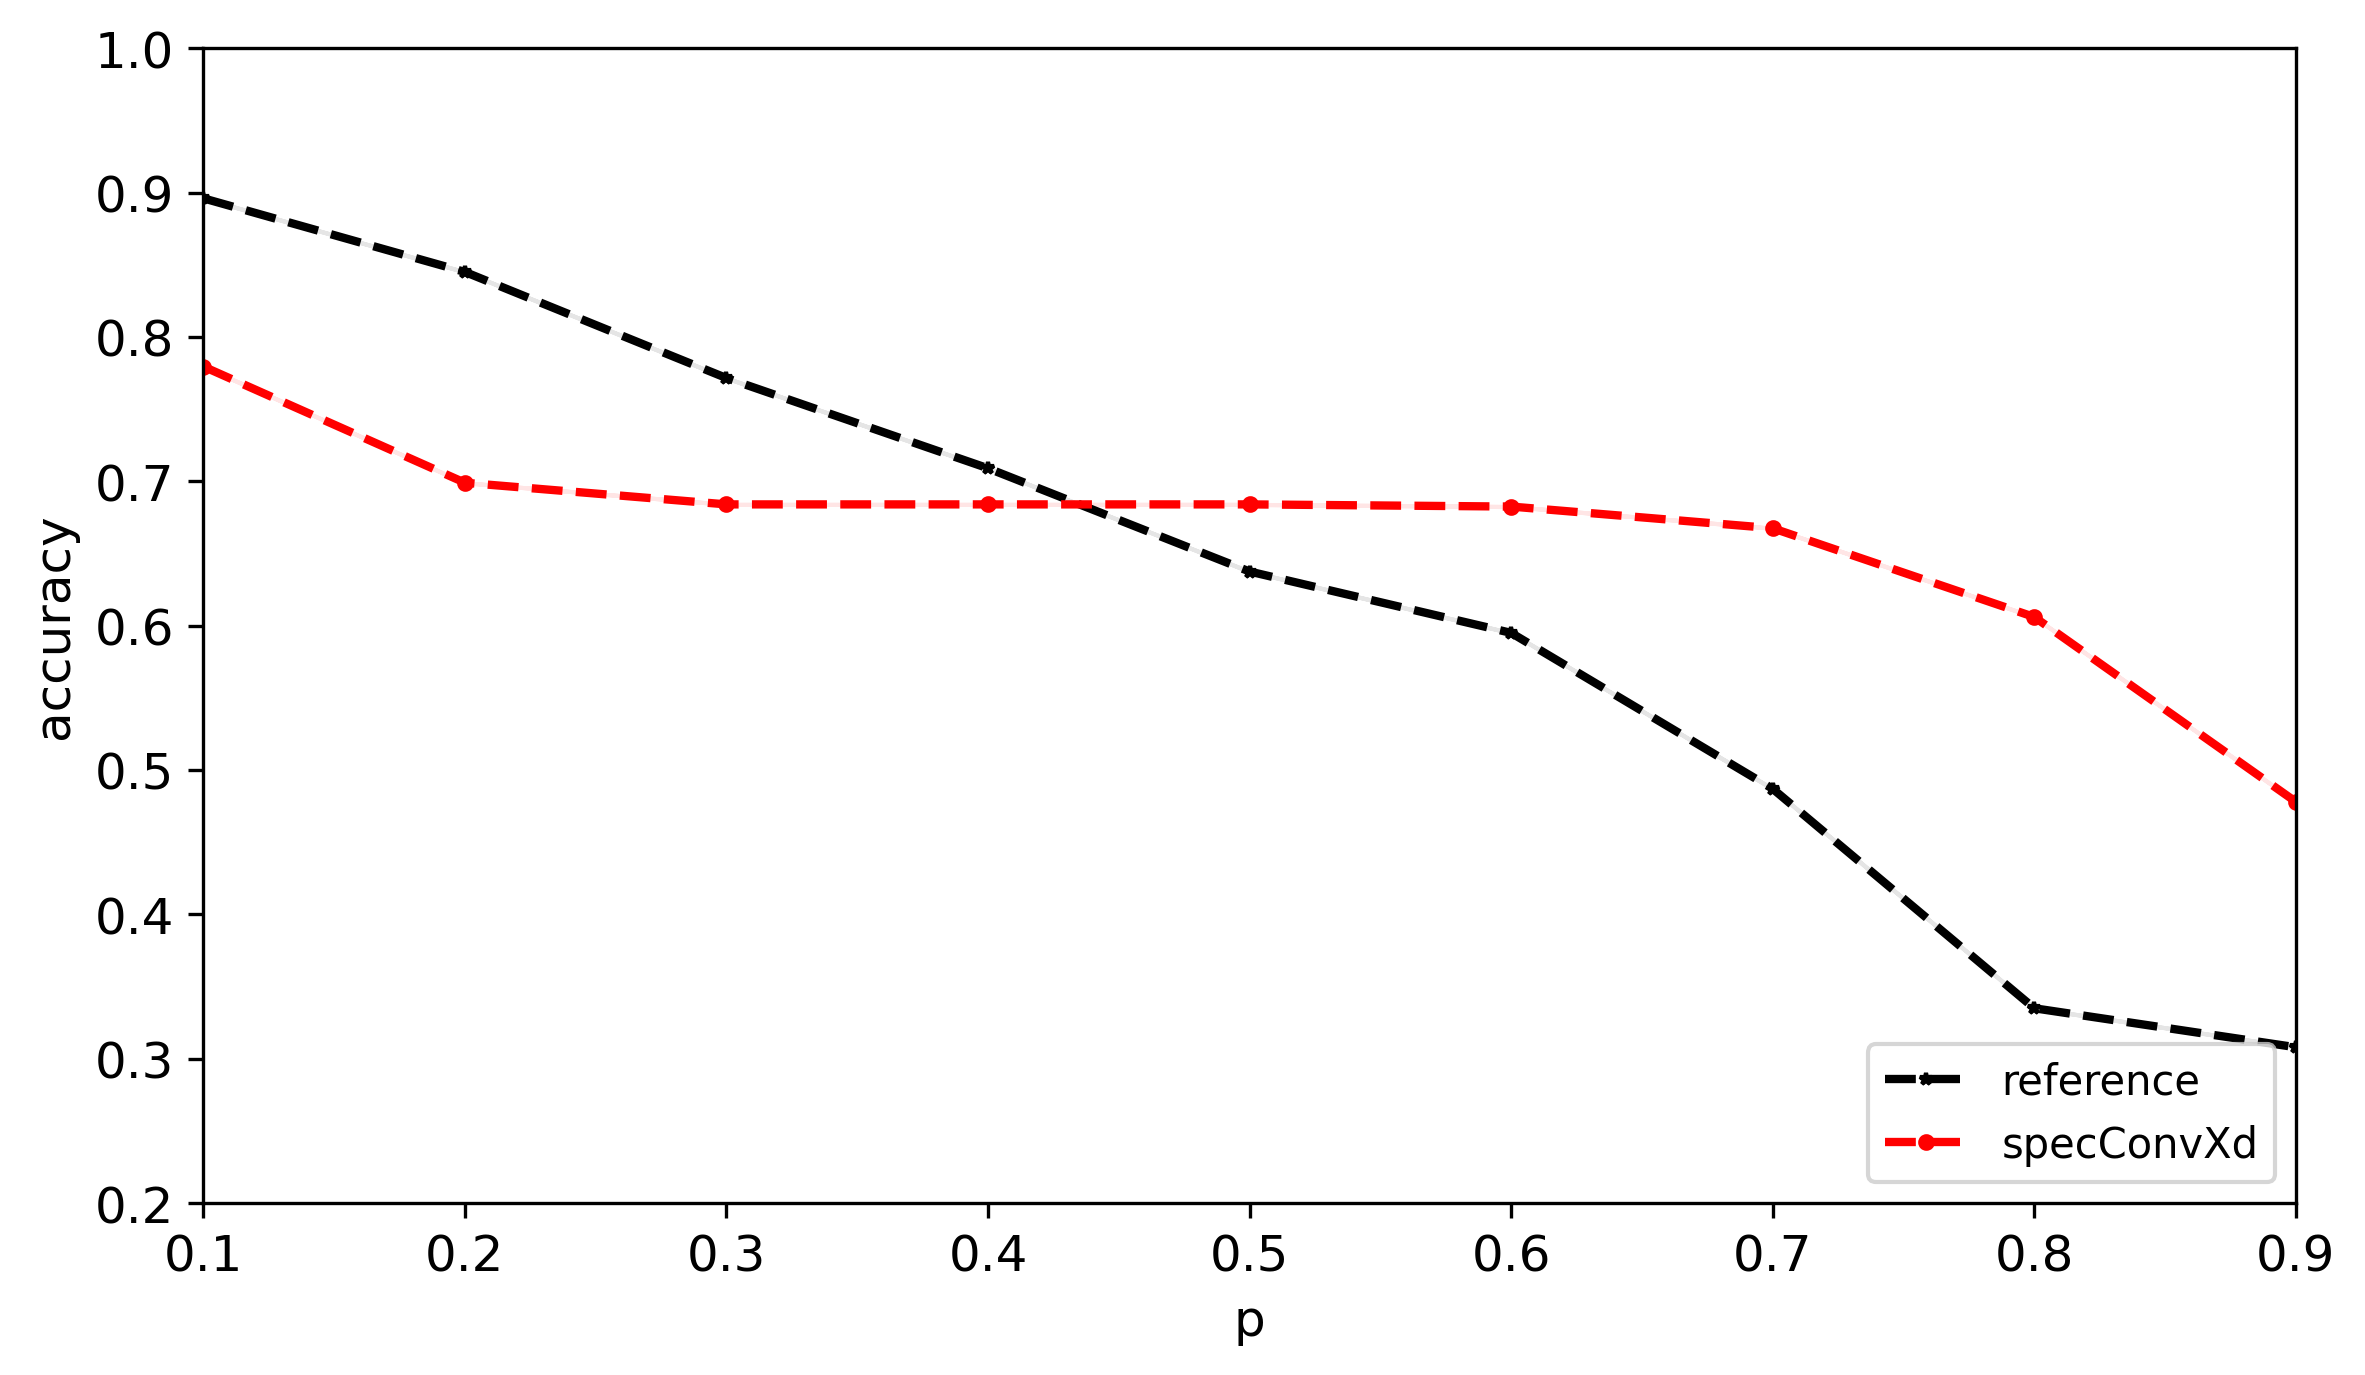

In [47]:
spc.plot_results(results,x_min=0.1,
            x_max=0.9,
            y_min=0.2,
            y_max=1.0,
            xlabel='p',
            ylabel='accuracy',
            show_fig=True,
            use_grid=False,
            markersize=3,
            percentile=True,
            save_fig=False,
            dpi=300,
            loc='lower right',
            name_fig='results')